# Numba

## Why is Python Slow?

In [34]:
a = 2

In [35]:
type(a)

int

In [36]:
a

2

The `a` is an `int` python object. It has `data` and `methods` that enable it to behave like an `integer` in a very general way. 

In [37]:
# All the methods associated with variable 'a'
dir(a)

['__abs__',
 '__add__',
 '__and__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 '__xor__',
 'as_integer_ratio',
 'bit_length',
 'conjugate',
 'denominator',
 'from_bytes',
 'imag',
 'numerator',
 'real',
 'to_bytes']

What do these methods do? Allow for comparison operators etc.

In [38]:
a == 2

True

In [39]:
a.__eq__(2)

True

# What about NumPy?

In [40]:
import numpy as np

In [41]:
b = np.array([2])

In [42]:
b[0]

2

In [43]:
type(b[0])

numpy.int64

Rather than a general `int` of arbitrary size this is an `int64` value. 

It can only represent 64-bit integers and the maximum value is: 9,223,372,036,854,775,807

In [44]:
b[0] = 9223372036854775807

In [45]:
b[0]

9223372036854775807

In [46]:
b[0] + 1

<ipython-input-46-9feb3951cf2a>:1: RuntimeWarning: overflow encountered in long_scalars
  b[0] + 1


-9223372036854775808

**Question:** What happens with `python int` objects?

In [47]:
dir(b[0])

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_interface__',
 '__array_priority__',
 '__array_struct__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__xor__',
 'all',
 'any',
 'argmax',


**Note:** These are still objects, but the array operators of NumPy provide an automatic interface to run operations over the array of values lower down in `C` and `Fortran` then it casts those results back into `python`

In [48]:
b[0].data

The in-memory representation of `numpy` follows `C` in-memory structure

![](img/numpy-memory.png)

## Numba + Fast Loops (A Time Series Model)

In [49]:
import numpy as np
from numba import vectorize, jit, float64
import matplotlib.pyplot as plt

Consider the time series model

$$ x_{t+1} = \alpha x_t (1 - x_t) $$

Let's set $\alpha = 4$

In [50]:
α = 4

Here's a typical time series:

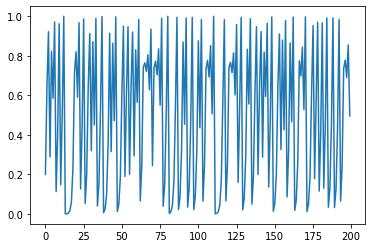

In [51]:
n = 200
x =  np.empty(n)
x[0] = 0.2
for t in range(n-1):
    x[t+1] = α * x[t] * (1 - x[t])
    
plt.plot(x)
plt.show()

Here's a function that simulates for `n` periods, starting from `x0`, and returns **only the final** value:

In [52]:
def quad(x0, n):
    x = x0
    for i in range(1, n):
        x = α * x * (1 - x)
    return x

Let's see how fast this runs:

In [53]:
n = 10_000_000

In [54]:
%%time
x = quad(0.2, n)

CPU times: user 1.12 s, sys: 6.21 ms, total: 1.13 s
Wall time: 1.13 s


Now you could write this in FORTRAN.  

A **Fortran** Program:

```fortran
PURE FUNCTION QUAD(X0, N)
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                           
 REAL(dp), INTENT(IN) :: X0
 REAL(dp) :: QUAD
 INTEGER :: I
 INTEGER, INTENT(IN) :: N
 QUAD = X0
 DO I = 1, N - 1                                                
  QUAD = 4.0_dp * QUAD * real(1.0_dp - QUAD, dp)
 END DO
 RETURN
END FUNCTION QUAD

PROGRAM MAIN
 IMPLICIT NONE
 INTEGER, PARAMETER :: DP=KIND(0.d0)                          
 REAL(dp) :: START, FINISH, X, QUAD
 INTEGER :: N
 N = 10000000
 X = QUAD(0.2_dp, 10)
 CALL CPU_TIME(START)
 X = QUAD(0.2_dp, N)
 CALL CPU_TIME(FINISH)
 PRINT *,'last val = ', X
 PRINT *,'elapsed time = ', FINISH-START
END PROGRAM MAIN
```

and compiling this with a `fortran` compiler

```bash
gfortran -O3 fastquad.f90
```

gives you the results

```
last val =   0.46200166384322749     
elapsed time =    3.5999999999999997E-002
```

when you run the program `a.out` (on this machine)

It is a `lot` quicker than python

Now let's do the same thing in Python using Numba's JIT compilation:

In [55]:
quad_jitted = jit(quad)

In [56]:
%%time
x = quad_jitted(0.2, n)

CPU times: user 99.8 ms, sys: 4.61 ms, total: 104 ms
Wall time: 105 ms


In [57]:
%%time
x = quad_jitted(0.2, n)

CPU times: user 30.9 ms, sys: 1.27 ms, total: 32.2 ms
Wall time: 33.5 ms


**Question:** Why did the second one take less time to run?

After JIT compilation, function execution speed is about the same as FORTRAN.

But remember, JIT compilation for Python is still limited --- see [here](http://numba.pydata.org/numba-doc/dev/reference/pysupported.html) but has grown very quickly and supports a very large part of `numpy`.

# Review `numba` acceleration from Product Space Example

In [58]:
import pandas as pd
import numpy as np

# Fetch Data and Setup RCA Data
fl = "../session1/data/year_origin_sitc_rev2.csv"
data = pd.read_csv(fl, converters={'sitc':str})   #Import SITC codes as strings to preserve formatting
cntry_export = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).sum()
cntry_export.head(n=2)
data["cntry_export"] = data[["year", "origin", "export"]].groupby(by=["year", "origin"]).transform(np.sum)
data["prod_export"] = data[["year", "sitc", "export"]].groupby(by=["year", "sitc"]).transform(np.sum)
data["world_export"] = data[["year", "export"]].groupby(by=["year"]).transform(np.sum)
data["rca"] = (data["export"] / data["cntry_export"]) / (data["prod_export"] / data["world_export"])

#-Generate Yearly RCA Mcp Matrices and store them in a Dictionary-#
rca = {}
for year in data.year.unique():
    yr = data[data.year == year].set_index(['origin', 'sitc']).unstack('sitc')['rca']
    rca[year] = yr
    
#-Generate Yearly Binary Mcp Matrices-#
mcp = {}
for year in rca.keys():
    mcp[year] = rca[year].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

--------------

## Computing Proximity Matrix $\phi_{ij}$

**Proximity:** A **high** proximity value suggests any two products are exported by a similar set of countries. 

$$
\phi_{ij} = \min \{ P(RCA_i >=1 \hspace{0.25cm} | \hspace{0.25cm} RCA_j >= 1), P(RCA_j >= 1 \hspace{0.25cm} | \hspace{0.25cm} RCA_i >= 1) \}
$$

The minimum **conditional probability of coexport** can be computed:

$$
\phi_{ij} = \frac{\sum_c \{ M_{cp_i} * M_{cp_j} \}}{max \{k_{p_i}, k_{p_j}\}}
$$

where,

1. $k_{p_i}$ is the ubiquity of product $i$ (i.e. the number of countries that export product $i$)
2. $k_{p_j}$ is the ubiquity of product $j$ (i.e. the number of countries that export product $j$)
2. $M_{cp_i}$ is the column vector in $M_{cp}$ matrix for product $i$
3. $M_{cp_j}$ is the column vector in $M_{cp}$ matrix for product $j$
4. $\sum_c \{ M_{cp_i} * M_{cp_j} \}$ is the number of countries that export both product $i$ and product $j$

The $\phi_{ij}$ matrix is therefore computed through all pairwise combinations of column vectors which is computationally intensive.

# Computing this matrix using Pandas

In [59]:
def proximity_matrix_pandas(mcp, fillna=True):
    products = sorted(list(mcp.columns))
    sum_products = mcp.sum(axis=0)
    proximity = pd.DataFrame(index=products, columns=products)
    for i, product1 in enumerate(products):
        for j, product2 in enumerate(products):
            if j > i:  #Symmetric Matrix Condition
                continue
            numerator = (mcp[product1] * mcp[product2]).sum()
            denominator = max(sum_products[product1], sum_products[product2])
            if denominator == 0:
                cond_prob =  np.nan
            else:
                cond_prob = numerator / denominator
            proximity.at[product1, product2] = cond_prob
            proximity.at[product2, product1] = cond_prob
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [60]:
%%time
prox_2000 = proximity_matrix_pandas(mcp[2000])

CPU times: user 1min 24s, sys: 814 ms, total: 1min 25s
Wall time: 1min 25s


# Computing this using Numba

**Reminder:** We found the main time was computing the pairs of co-export probability

In [61]:
from numba import jit

In [62]:
@jit(nopython=True)
def coexport_probability(data, num_products, col_sums):
    proximity = np.empty((num_products, num_products))
    for index1 in range(0,num_products):
        for index2 in range(0,num_products):
            if index2 > index1:
                continue
            numerator = (data[index1] * data[index2]).sum()
            denominator = max(col_sums[index1], col_sums[index2])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[index1][index2] = cond_prob
            proximity[index2][index1] = cond_prob
    return proximity

def proximity_matrix_numba(mcp, fillna=False):
    products = sorted(list(mcp.columns))
    num_products = len(products)
    col_sums = mcp.sum().values  
    data = mcp.T.values                  
    proximity = coexport_probability(data, num_products, col_sums)   #Call Jit Function
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'productcode1'
    proximity.columns.name = 'productcode2'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

In [63]:
%%time
prox_2000_numba = proximity_matrix_numba(mcp[2000])

CPU times: user 369 ms, sys: 5.72 ms, total: 375 ms
Wall time: 376 ms


In [64]:
prox_2000.equals(prox_2000_numba)

True

## Inspecting how JIT works

In [65]:
coexport_probability.inspect_types()

coexport_probability (array(float64, 2d, C), int64, array(float64, 1d, C))
--------------------------------------------------------------------------------
# File: <ipython-input-62-65aa5d38f6b9>
# --- LINE 1 --- 

@jit(nopython=True)

# --- LINE 2 --- 

def coexport_probability(data, num_products, col_sums):

    # --- LINE 3 --- 
    # label 0
    #   data = arg(0, name=data)  :: array(float64, 2d, C)
    #   num_products = arg(1, name=num_products)  :: int64
    #   col_sums = arg(2, name=col_sums)  :: array(float64, 1d, C)
    #   $2load_global.0 = global(np: <module 'numpy' from '/Users/matthewmckay/anaconda3/lib/python3.8/site-packages/numpy/__init__.py'>)  :: Module(<module 'numpy' from '/Users/matthewmckay/anaconda3/lib/python3.8/site-packages/numpy/__init__.py'>)
    #   $4load_method.1 = getattr(value=$2load_global.0, attr=empty)  :: Function(<built-in function empty>)
    #   del $2load_global.0
    #   $10build_tuple.4 = build_tuple(items=[Var(num_products, <ipython-input-6